# Suitable title

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
sns.set_style('darkgrid') # Set plot to darkgrid background

## Trend

In [3]:
from pytrends.request import TrendReq

Based on research, the popular keyword is 'coronavirus'. It is several types more popular than 'corona virus', 'covid' and 'covid19'. 'coronavirus' is included in suggestion for all related title and the trend is similar (correlated).

In [4]:
kw_list = ['coronavirus']  #keyword list
pytrends = TrendReq()
pytrends.build_payload(kw_list, geo='DE', timeframe='2020-01-01 2020-09-30')
trend = pytrends.interest_over_time()

In [5]:
trend.head()

,coronavirus,isPartial
date,,
2020-01-05,0,False
2020-01-12,0,False
2020-01-19,5,False
2020-01-26,26,False
2020-02-02,12,False


As you can see, it is weekly trend rather than daily. The reason is because the date range is more than 8 months.
There are two solutions.
1. Forward fill and backward fill.
2. Use np.linspace to gradually increase or decrease the trend.

However, I think it would be better to first get the data for 6 months, then the data for the next three month. The next three months has to be rescaled in other to fit the 6 months trend.

In [6]:
# The first 6 months
pytrends.build_payload(kw_list, geo='DE', timeframe='2020-01-01 2020-06-01')
first6 = pytrends.interest_over_time()

# The last three month
pytrends.build_payload(kw_list, geo='DE', timeframe='2020-06-01 2020-09-30')
last3 = pytrends.interest_over_time()

# Drop isPartial column
first6.drop('isPartial', axis=1, inplace=True)
last3.drop('isPartial', axis=1, inplace=True)

In [7]:
# Find the ratio and rescale the last 3 months
ratio = first6.iloc[-1, 0]/last3.iloc[0,0]
scaled_last3 = (last3*ratio).astype(int)

# Drop 06-01 in first6 to avoid duplicates
first6.drop(np.datetime64('2020-06-01'), inplace=True)

# Concat the table
trend = pd.concat([first6, scaled_last3])
trend.columns = ['Trends']

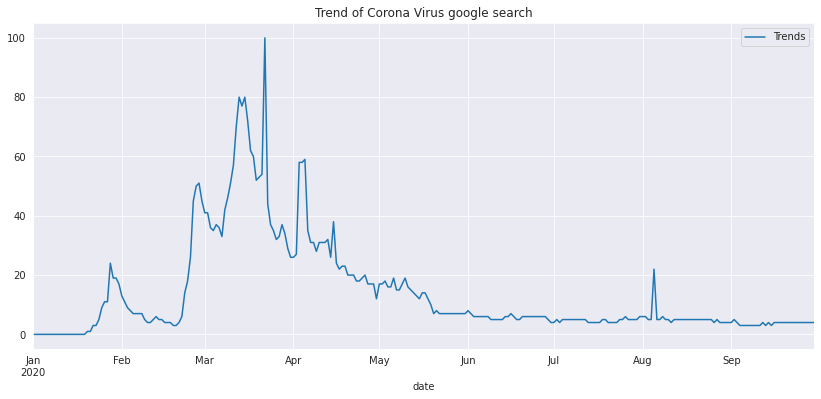

In [8]:
trend.plot(figsize=(14,6))
plt.title('Trend of Corona Virus google search')
plt.savefig('Trend')
plt.show()


## Cases and death

In [10]:
from bs4 import BeautifulSoup
import requests
import json
import numpy as np

In [11]:
res = requests.get('https://www.worldometers.info/coronavirus/country/germany/')
res.raise_for_status
soup = BeautifulSoup(res.text, 'lxml')

In [12]:
def has_data(string):
    return 'Highcharts.chart' in str(string)

scripts = soup.find_all('script', attrs={'type': 'text/javascript'}, string=has_data)
scripts
# The NEW DAILY cases and deaths
#cases_string = str(scripts[3].string)
#deaths_string = str(scripts[6].string)

[<script type="text/javascript">
     Highcharts.setOptions({
         lang: {
             thousandsSep: ','
         }
     });
 
     var y_labels = ['0', '20,000', '40,000', '60,000', '140', '180', '200', '240'];
     Highcharts.chart('total-currently-infected-linear', {
 
 
         chart: {
             type: 'line',
             height: (9 / 16 * 100) + '%'
         },
 
         title: {
             text: null
 
         },
 
         /*subtitle: {
             text: '(Number of Infected People)'
         },*/
 
         xAxis: {
             categories: ["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 0

In [13]:
# Manipulating the strings to get the data needed
cases_string = cases_string[cases_string.find("name: 'Daily Cases'"): ]   # The daily section
cases_string = cases_string[cases_string.find('data: '):] # The data_section
cases_data = cases_string[6: cases_string.find(']')+1].replace('null', '0')  

# Note. It is important to replace null with 0 because json would parse null as None (which can't be converted to int)
cases = np.array([int(x) for x in json.loads(cases_data)])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

#### Do same thing to find deaths too

In [13]:
deaths_string = deaths_string[deaths_string.find("name: 'Daily Deaths'"): ]   # The daily section
deaths_string = deaths_string[deaths_string.find('data: '):] # The data_section
deaths_data = deaths_string[6: deaths_string.find(']')+1].replace('null', '0')
deaths = np.array([int(x) for x in json.loads(deaths_data)])

Note that the data starts from 02-15 to date. Therefore, the value is 0 before 02-15 and we have to drop values after 09-30.

There are 45 days between 01-01 to 02-14, and 229 from 02-15 to 09-30. Therefore we will take the first 229 items in cases and death, and add 45 zeros to the front

In [14]:
zeros = np.zeros(45, int)
cases = np.append(zeros, cases[:229])
deaths = np.append(zeros, deaths[:229])

In [15]:
# Turn it into a dataframe
corona_stats = pd.DataFrame({'Cases': cases, 'Deaths': deaths}, index=np.arange('2020-01-01', '2020-10-01', dtype='datetime64'))
corona_stats.head()

,Cases,Deaths
2020-01-01,0,0
2020-01-02,0,0
2020-01-03,0,0
2020-01-04,0,0
2020-01-05,0,0


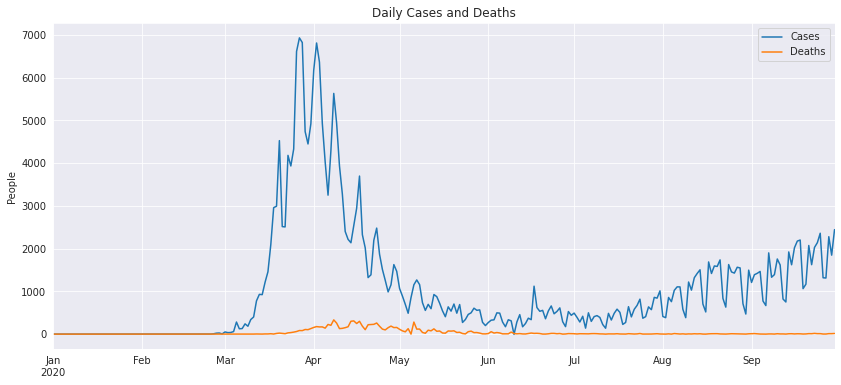

In [16]:
corona_stats.plot(figsize=(14,6))
plt.title('Daily Cases and Deaths')
plt.ylabel('People')
plt.savefig('Cases and Deaths')
plt.show()

## Dax performance index

In [17]:
# There's an easy way to get dax performance index. The address below is the csv file for 01-01-2020 to 30-09-2020
address = 'https://query1.finance.yahoo.com/v7/finance/download/%5EGDAXI?period1=1577750400&period2=1601510400&interval=1d&events=history&includeAdjustedClose=true'
dax = pd.read_csv(address)

In [18]:
dax.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,13233.709961,13425.030273,13225.160156,13385.929688,13385.929688,75341400
1,2020-01-03,13266.389648,13282.740234,13120.719727,13219.139648,13219.139648,80793400
2,2020-01-06,13085.490234,13143.110352,12948.169922,13126.990234,13126.990234,71778600
3,2020-01-07,13199.589844,13283.879883,13166.400391,13226.830078,13226.830078,78282300
4,2020-01-08,13140.490234,13334.040039,13106.269531,13320.179688,13320.179688,88178800


In [19]:
dax.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.997235,0.996004,0.992955,0.992955,-0.623380
High,0.997235,1.000000,0.996016,0.995951,0.995951,-0.611264
Low,0.996004,0.996016,1.000000,0.997309,0.997309,-0.650336
Close,0.992955,0.995951,0.997309,1.000000,1.000000,-0.647333
Adj Close,0.992955,0.995951,0.997309,1.000000,1.000000,-0.647333
Volume,-0.623380,-0.611264,-0.650336,-0.647333,-0.647333,1.000000


Everything is very correlated so we'll pick only Close. 01-01 is not included so we'll take that as 02-01 Open.

In [20]:
dax_performance = pd.DataFrame(data = np.array(dax['Close']), index=dax.Date.astype(np.datetime64), columns=['Dax'])

# Include 01-01
dax_performance.loc[np.datetime64('2020-01-01'), 'Dax'] = dax.loc[0, 'Open']

#See the head. Don't worry, 01-01 is at the tail.
dax_performance.head()

,Dax
Date,
2020-01-02,13385.929688
2020-01-03,13219.139648
2020-01-06,13126.990234
2020-01-07,13226.830078
2020-01-08,13320.179688


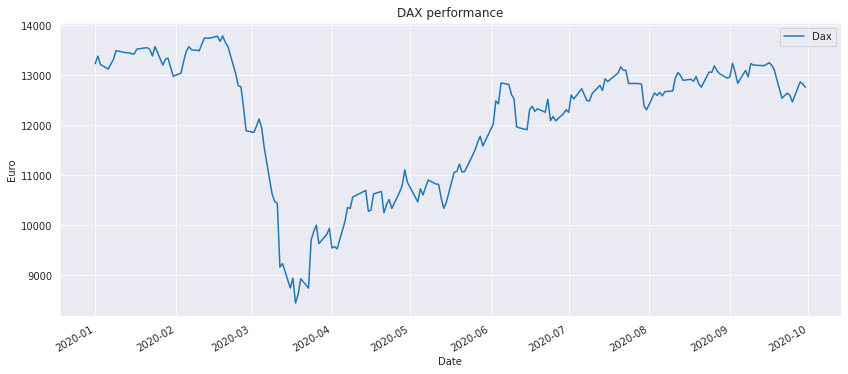

In [21]:
dax_performance.plot(figsize=(14,6))
plt.title('DAX performance')
plt.ylabel('Euro')
plt.savefig('Dax performance')
plt.show()

## Concatenate everything

In [22]:
df = pd.concat([trend, corona_stats, dax_performance], axis=1)
df.tail(10)

,Trends,Cases,Deaths,Dax
2020-09-21,4,2074,11,12542.440430
2020-09-22,4,1625,10,12594.389648
2020-09-23,4,2029,17,12642.969727
2020-09-24,4,2140,11,12606.570313
2020-09-25,4,2361,11,12469.200195
2020-09-26,4,1319,2,NaN
2020-09-27,4,1313,2,NaN
2020-09-28,4,2280,11,12870.870117
2020-09-29,4,1848,11,12825.820313
2020-09-30,4,2445,15,12760.730469


As you might have noticed, DAX has nan values during weekends and holiday. The solution is to forward fill. Let's also save it to csv file.

In [23]:
df.describe()

,Trends,Cases,Deaths,Dax
count,274.000000,274.000000,274.000000,192.000000
mean,13.981752,1068.959854,34.930657,12132.363164
std,17.135840,1384.818839,66.783607,1318.938054
min,0.000000,-6.000000,0.000000,8441.709961
25%,4.000000,148.000000,0.000000,11071.885010
50%,6.000000,569.500000,6.000000,12617.395019
75%,18.000000,1426.750000,24.000000,13103.604736
max,100.000000,6933.000000,333.000000,13789.000000


In [24]:
#Fillna
df.fillna(method='ffill', inplace=True)

#Save to csv
df.to_csv('dataset.csv')

df.describe()

,Trends,Cases,Deaths,Dax
count,274.000000,274.000000,274.000000,274.000000
mean,13.981752,1068.959854,34.930657,12093.034928
std,17.135840,1384.818839,66.783607,1320.622965
min,0.000000,-6.000000,0.000000,8441.709961
25%,4.000000,148.000000,0.000000,10943.077881
50%,6.000000,569.500000,6.000000,12603.720215
75%,18.000000,1426.750000,24.000000,13088.905274
max,100.000000,6933.000000,333.000000,13789.000000


#### The magnitude of the difference between each column won't make it suitable to plot so it would be normalized first

In [25]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [26]:
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
df_min_max = pd.DataFrame(min_max_scaler.fit_transform(df), columns=['Trend', 'Cases', 'Deaths', 'Dax'])
df_standard = pd.DataFrame(standard_scaler.fit_transform(df), columns=['Trend', 'Cases', 'Deaths', 'Dax'])

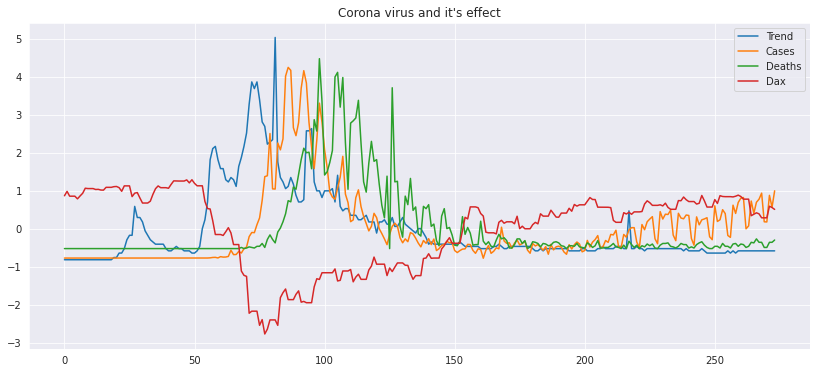

In [27]:
df_standard.plot(figsize=(14,6))
plt.title("Corona virus and it's effect")
plt.savefig('Effect of corona virus')
plt.show()

#### It is obvious that the pandemic significantly affects Dax performance. Another thing to notice is that trend comes first. There's more trend before more cases, and then more deaths, while the death and cases reduces AFTER the trend reduces. This seems counter-intuitive.

## Correlation

In [28]:
df.corr()

,Trends,Cases,Deaths,Dax
Trends,1.000000,0.421927,0.282293,-0.764313
Cases,0.421927,1.000000,0.568510,-0.614577
Deaths,0.282293,0.568510,1.000000,-0.579326
Dax,-0.764313,-0.614577,-0.579326,1.000000
